# Evaluating classifier results

In [1]:
from evaluate_results import get_score_df, load_histo_file
from typing import List
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

Paths to result files. These can be downloaded from the results folder in the project Drive folder.

If you have a different set of results, you'll want to replace these values. Then the rest of the notebook should run fine.

There's some lists of old results files commented here, for convenience of the author.

In [2]:
# RESULTS_PATHS: List[str] = [
#     "test_all_export3.csv",
#     "N_east_all.csv",
#     "N_se_h1-cc80.csv",
#     "indonesia_1_0200.csv",
#     "indonesia_2_200.csv",
#     "indonesia_2_180.csv"
# ]
RESULTS_PATHS: List[str] = [
    "hexas_west13_preLabels.csv",
    "hexas_west14_pre_asc.csv",
    "hexas_west14_pre_desc.csv",
    "hexas_west15_jaxa.csv",
    "hexas_west17_jaxa.csv",
    "prg-Prelabels_12.csv",
]
# RESULTS_PATHS: List[str] = [
#     "hexas_west12.csv",
#     "hexas_west11_desc300.csv",
#     "hexas_west11_asc300.csv",
# ]
# RESULTS_PATHS: List[str] = [
#     "subset1_finland_auto.csv"
# ]
RESULTS_DIR = "results/"

Load results, expecting them to be of the form as the files listed above, in a direc.

In [3]:
results = {path: load_histo_file(RESULTS_DIR + path) for path in RESULTS_PATHS}

Now we merge the visual interpretation data in. This requires you to have the data at the appropriate path. Again, this data file can be downloaded from Drive, this time from the labels directory.

Alternatively, you can create the relevant CSVs yourself from the xlsx files provided by the client by running the scripts `xlsx_to_csv.py` and `train_test_split.py` successively.

**NB: We specifically use "training_complete.csv" because the test data is intended to be reserved only for evaluation of the system at the end of the project.**

In [4]:
labels_df = pd.read_csv("label_CSVs/training_complete.csv")

# Remove any lines corresponding to unstocked forest (as of 2018), because one cannot reliably determine tree cover from land use in those cases.
print(labels_df.shape)

labels_df = labels_df.loc[
    (
        labels_df["Sub-Categories if Naturally regenerated forest"]
        != "Temporarily unstocked forest"
    )
    & (
        labels_df["Sub-Categories if Planted forest"]
        != "Temporarily unstocked planted forest"
    ),
    :,
]

print(labels_df.shape)

results_w_labels = dict()
for path, df in results.items():
    results_w_labels[path] = pd.merge(df, labels_df, how="inner", left_on="plotID",right_on="pl_plotid")


(33460, 31)
(32080, 31)
/home/onniaarn/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


The block below prints the mean absolute errors, precision, recall, etc. of the different results files.

Precision and recall are calculated while treating the model as a binary forest loss or forest gain detector.

The F-5.0 column refers to an [$F_\beta$ score](https://en.wikipedia.org/wiki/F-score) with $\beta=5$. If you wish to use a different beta, you can pass it to `get_score_df` using the keyword arguent `beta`.

In [5]:
for path, df in results_w_labels.items():
    print(path)
    print(get_score_df(df))

hexas_west13_preLabels.csv
                               MAE  Correlation  % Precision   % Recall  \
% Forest Loss 2000-2010  21.986298     0.452269    43.492063  90.131579   
% Forest Loss 2010-2018  25.834273     0.518373    60.471204  98.297872   
% Forest Gain 2000-2010   0.161819          NaN     0.000000        NaN   
% Forest Gain 2010-2018   0.061325          NaN     0.000000        NaN   

                            F-5.0  Avg. actual  Avg. predicted  
% Forest Loss 2000-2010  0.865614    26.374696       18.043389  
% Forest Loss 2010-2018  0.959885    41.581509       36.623843  
% Forest Gain 2000-2010  0.000000     0.000000        0.161819  
% Forest Gain 2010-2018  0.000000     0.000000        0.061325  
hexas_west14_pre_asc.csv
                               MAE  Correlation  % Precision   % Recall  \
% Forest Loss 2000-2010  25.399610     0.599459    70.198675  89.075630   
% Forest Loss 2010-2018  22.050730     0.492454    42.857143  90.697674   
% Forest Gain 2000-201

## Saving the cleaned data

If you wish, you can run the block below to save the processessed results files with the proper percentages as CSVs. 

In [7]:
CLEAN_DIR = "cleaned_results/"

if not os.path.exists(CLEAN_DIR):
    os.mkdir(CLEAN_DIR)

for path, df in results_w_labels.items():
    df.to_csv(CLEAN_DIR + path)

## Visualizing results

In [7]:
total_df = pd.concat(results_w_labels.values())

In [52]:
get_score_df(total_df)

,MAE,Correlation,% Precision,% Recall,Avg. actual,Avg. predicted
% Forest Loss 2000-2010,23.400334,0.494917,53.997683,85.661765,31.073620,14.004094
% Forest Loss 2010-2018,24.866989,0.489384,50.891266,96.779661,33.466258,30.165637
% Forest Gain 2000-2010,0.602005,-0.003924,0.000000,0.000000,0.061350,0.540655
% Forest Gain 2010-2018,0.198271,-0.008019,0.000000,0.000000,0.122699,0.075572


First, we plot actual deforestation against deforestation according to the visual interpreters. For clarity, hexas for which there was no deforestation according to the visual interpreters are visualized separately as a histogram below.

You may want to adjust the definition of `df` below to match whatever set of results you wish to visualize.

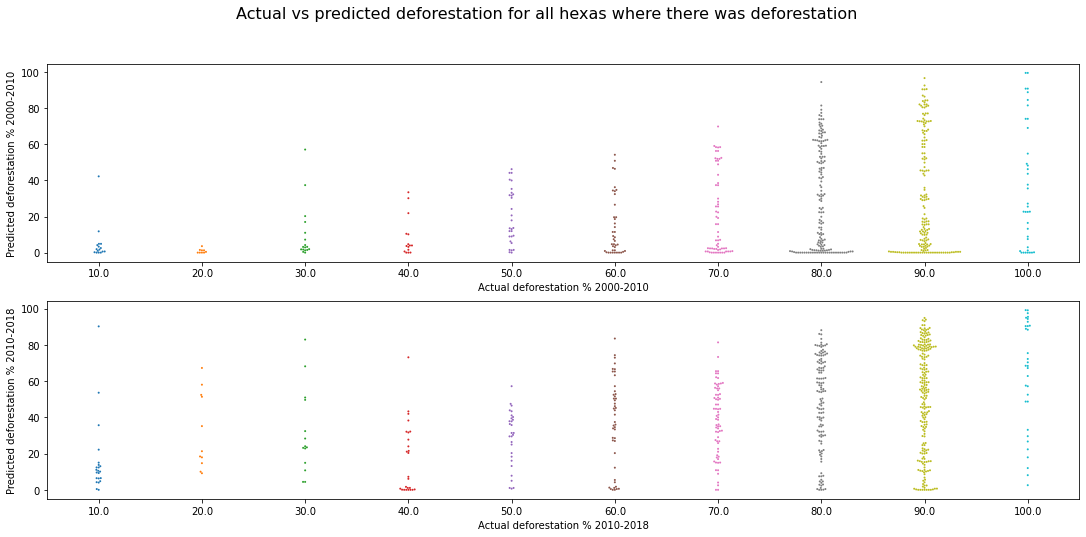

In [9]:
df = total_df
fig, axes = plt.subplots(2, 1)
fig.set_size_inches(18.5, 8)
w_change_2000 = total_df.loc[total_df["% Forest Loss 2000-2010"] >= 10, :]
w_change_2010 = total_df.loc[total_df["% Forest Loss 2010-2018"] >= 10, :]
sns.swarmplot(x=w_change_2000["% Forest Loss 2000-2010"], y=w_change_2000["deforestation 2000-2010"], size=2, ax=axes[0])
axes[0].set_ylabel("Predicted deforestation % 2000-2010")
axes[0].set_xlabel("Actual deforestation % 2000-2010")
sns.swarmplot(x=w_change_2010["% Forest Loss 2010-2018"], y=w_change_2010["deforestation 2010-2018"], size=2, ax=axes[1])
axes[1].set_ylabel("Predicted deforestation % 2010-2018")
axes[1].set_xlabel("Actual deforestation % 2010-2018")
fig.suptitle("Actual vs predicted deforestation for all hexas where there was deforestation", fontsize=16)
plt.show()

In [20]:
print(w_change_2000.shape)
print(w_change_2010.shape)

(4, 52)
(2, 52)


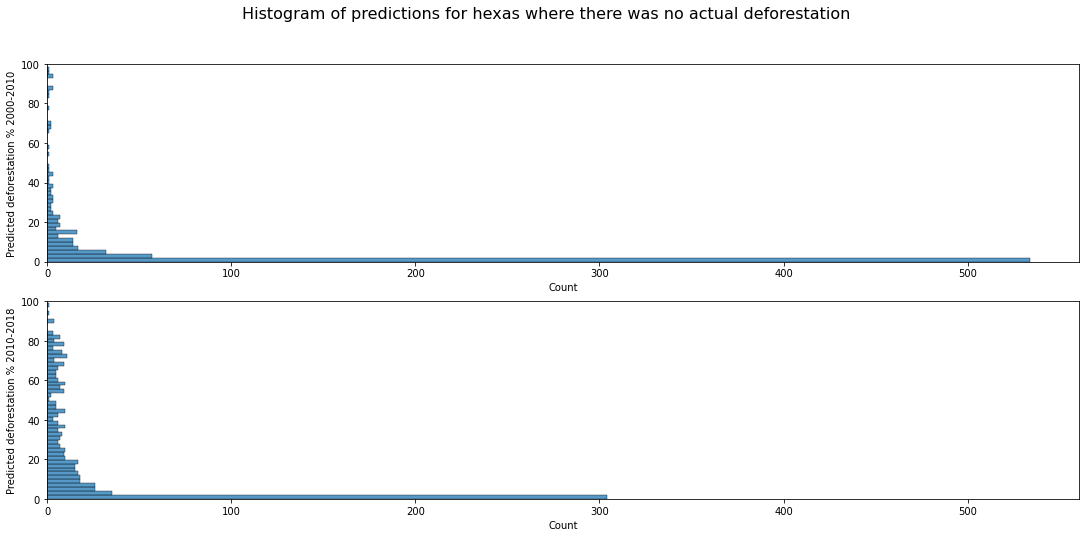

In [10]:
df = total_df
fig, axes = plt.subplots(2, 1)
fig.set_size_inches(18.5, 8)
w_no_change_2000 = total_df.loc[total_df["% Forest Loss 2000-2010"] < 10, :]
w_no_change_2010 = total_df.loc[total_df["% Forest Loss 2010-2018"] < 10, :]
sns.histplot(y=w_no_change_2000["deforestation 2000-2010"], ax=axes[0], bins=50)
sns.histplot(y=w_no_change_2010["deforestation 2010-2018"], ax=axes[1], bins=50)
x_lim = max(axes[0].get_xlim(), axes[1].get_xlim())
y_lim = (0, 100)
axes[0].set_xlim(x_lim)
axes[0].set_ylim(y_lim)
axes[1].set_xlim(x_lim)
axes[1].set_ylim(y_lim)
axes[0].set_ylabel("Predicted deforestation % 2000-2010")
axes[1].set_ylabel("Predicted deforestation % 2010-2018")
fig.suptitle("Histogram of predictions for hexas where there was no actual deforestation", fontsize=16)
plt.show()

Both the swarm plot and histogram of Only one time period 

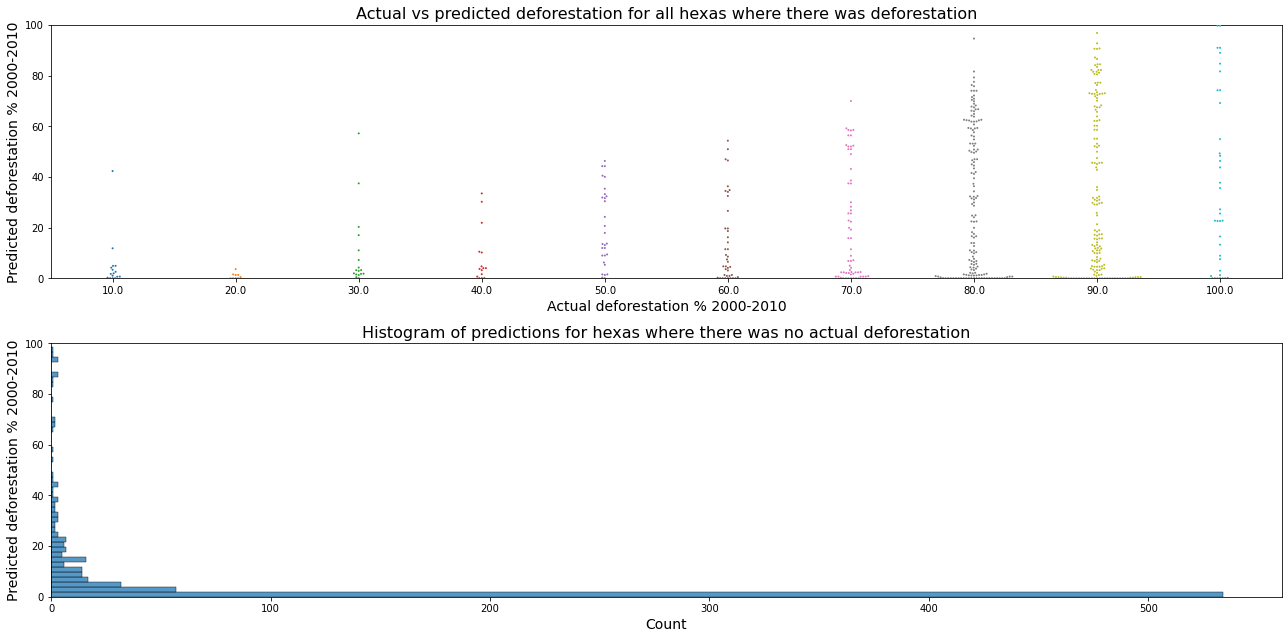

In [11]:
period = "2000-2010"

df = total_df
fig, axes = plt.subplots(2, 1)
fig.set_size_inches(18, 9)
w_no_change = total_df.loc[total_df["% Forest Loss " + period] < 10, :]
w_change = total_df.loc[total_df["% Forest Loss " + period] >= 10, :]
sns.swarmplot(x=w_change["% Forest Loss " + period], y=w_change["deforestation " + period], size=2, ax=axes[0])
sns.histplot(y=w_no_change["deforestation " + period], ax=axes[1], bins=50)
y_lim = (0, 100)
axes[0].set_ylim(y_lim)
axes[1].set_ylim(y_lim)
axes[0].set_ylabel("Predicted deforestation % " + period, fontsize=14)
axes[1].set_ylabel("Predicted deforestation % " + period, fontsize=14)
axes[0].set_xlabel("Actual deforestation % " + period, fontsize=14)
axes[1].set_xlabel("Count", fontsize=14)
axes[0].set_title("Actual vs predicted deforestation for all hexas where there was deforestation", fontsize=16)
axes[1].set_title("Histogram of predictions for hexas where there was no actual deforestation", fontsize=16)
# fig.suptitle("Histogram of predictions for hexas where there was no actual deforestation", fontsize=16)
plt.tight_layout()
plt.show()